In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import joblib
import numpy as np
import math
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from copy import deepcopy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [2]:
data = joblib.load("/kaggle/input/holedbach/jsb1-li-train.pkl")
X = data['X']

X = X.reshape(X.shape[0], 1, X.shape[1], X.shape[2]).astype(np.float32)

X = X * 2 - 1

X = X[:, :, 30:100, :]
print("Shape dei dati:", X.shape, "Max:", X.max(), "Min:", X.min())

dataloader = DataLoader(torch.tensor(X), batch_size=64, shuffle=True)

Shape dei dati: (2604, 1, 70, 100) Max: 1.0 Min: -1.0


In [3]:
T = 1000  
beta_start = 1e-4
beta_end = 0.02
betas = torch.linspace(beta_start, beta_end, T).to(device)
alphas = 1.0 - betas
alphas_bar = torch.cumprod(alphas, dim=0)

In [11]:
def matrix_to_grid_4d(matrix, grid_rows, grid_cols):
        """
        Divide un tensore 4D in una griglia di sotto-matrici (patch) non sovrapposte.

        Args:
            matrix (torch.Tensor): tensore 4D da dividere, di forma [N, C, H, W].
            grid_rows (int): numero di patch lungo l'asse verticale (altezza).
            grid_cols (int): numero di patch lungo l'asse orizzontale (larghezza).

        Returns:
            torch.Tensor: tensore contenente le patch, di forma [N, grid_rows*grid_cols, C, patch_height, patch_width].
        """
        N, C, H, W = matrix.shape
        patch_h = H // grid_rows
        patch_w = W // grid_cols

        patches = matrix.unfold(2, patch_h, patch_h).unfold(3, patch_w, patch_w)
        patches = patches.contiguous().view(N, C, grid_rows * grid_cols, patch_h, patch_w)
        patches = patches.permute(0, 2, 1, 3, 4)
        return patches

def grid_to_matrix_4d(patches, grid_rows, grid_cols):
        """
        Ricostruisce il tensore originale a partire da una griglia di patch.

        Args:
            patches (torch.Tensor): tensore contenente le patch, di forma
                [N, grid_rows*grid_cols, C, patch_h, patch_w].
            grid_rows (int): numero di patch lungo l'asse verticale.
            grid_cols (int): numero di patch lungo l'asse orizzontale.

        Returns:
            torch.Tensor: tensore ricostruito, di forma [N, C, grid_rows*patch_h, grid_cols*patch_w].
        """
        N, num_patches, C, patch_h, patch_w = patches.shape
        if num_patches != grid_rows * grid_cols:
            raise ValueError("Il numero totale di patch deve essere grid_rows * grid_cols")

        patches = patches.view(N, grid_rows, grid_cols, C, patch_h, patch_w)
        patches = patches.permute(0, 3, 1, 4, 2, 5).contiguous()
        return patches.view(N, C, grid_rows * patch_h, grid_cols * patch_w)

In [4]:
def positionalencoding2d(d_model, height, width):
    """
    Restituisce una matrice di posizional encoding di dimensione (d_model, height, width).
    d_model deve essere multiplo di 4.
    """
    if d_model % 4 != 0:
        raise ValueError("d_model deve essere multiplo di 4")
    pe = torch.zeros(d_model, height, width)
    d_model_half = d_model // 2
    div_term = torch.exp(torch.arange(0., d_model_half, 2) * -(math.log(10000.0) / d_model_half))
    pos_w = torch.arange(0., width).unsqueeze(1)
    pos_h = torch.arange(0., height).unsqueeze(1)
    pe[0:d_model_half:2, :, :] = torch.sin(pos_w * div_term).transpose(0, 1).unsqueeze(1).repeat(1, height, 1)
    pe[1:d_model_half:2, :, :] = torch.cos(pos_w * div_term).transpose(0, 1).unsqueeze(1).repeat(1, height, 1)
    pe[d_model_half::2, :, :] = torch.sin(pos_h * div_term).transpose(0, 1).unsqueeze(2).repeat(1, 1, width)
    pe[d_model_half+1::2, :, :] = torch.cos(pos_h * div_term).transpose(0, 1).unsqueeze(2).repeat(1, 1, width)
    return pe


embeddings = positionalencoding2d(T, 70, 100).to(device)


In [ ]:
import gc
gc.collect()

device = torch.device("cuda:0")  # Cambia a "cuda:1" se hai più GPU
with torch.cuda.device(device):
    torch.cuda.empty_cache()

torch.cuda.reset_peak_memory_stats()
torch.cuda.reset_accumulated_memory_stats()

In [74]:
class UNet(nn.Module):
    def __init__(self, base_channels=16):
        super(UNet, self).__init__()
        # Encoder: padding=1 per mantenere le dimensioni
        self.enc1 = nn.Conv2d(1, base_channels, kernel_size=3, stride=1, padding=1)           # Output: (batch, base_channels, 70, 100)
        self.enc2 = nn.Conv2d(base_channels, base_channels*2, kernel_size=3, stride=2, padding=1)  # Output: (batch, base_channels*2, 35, 50)
        self.enc3 = nn.Conv2d(base_channels*2, base_channels*4, kernel_size=3, stride=2, padding=1)  # Output: (batch, base_channels*4, 18, 25)
        self.enc4 = nn.Conv2d(base_channels*4, base_channels*8, kernel_size=3, stride=2, padding=1)  # Output: (batch, base_channels*8, 9, 13)
        
        self.dec3 = nn.ConvTranspose2d(base_channels*8, base_channels*4, kernel_size=3, stride=2,
                                       padding=1, output_padding=(1, 0))
        self.dec2 = nn.ConvTranspose2d(base_channels*4, base_channels*2, kernel_size=3, stride=2,
                                       padding=1, output_padding=(0, 1))
        self.dec1 = nn.ConvTranspose2d(base_channels*2, base_channels, kernel_size=3, stride=2,
                                       padding=1, output_padding=(1, 1))
        self.out_conv = nn.Conv2d(base_channels, 1, kernel_size=3, stride=1, padding=1)
        
        self.emb_conv = nn.Sequential(
            nn.Conv2d(1, base_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(base_channels, base_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(base_channels, 1, kernel_size=3, stride=1, padding=1)
        )
    
    def forward(self, x, t_emb):
        t_processed = self.emb_conv(t_emb)
        x = x + t_processed
        
        e1 = F.relu(self.enc1(x))
        e2 = F.relu(self.enc2(e1))
        e3 = F.relu(self.enc3(e2))
        e4 = F.relu(self.enc4(e3))
        
        d3 = F.relu(self.dec3(e4))
        d3 = d3 + e3
        d2 = F.relu(self.dec2(d3))
        d2 = d2 + e2
        d1 = F.relu(self.dec1(d2))
        d1 = d1 + e1
        out = self.out_conv(d1)
        
        return out

model = UNet(base_channels=64).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.L1Loss()

In [85]:
class DeNoiser(nn.Module):
    def __init__(self, c=32):
        super().__init__()
        
        self.conv1 = nn.ConvTranspose2d(in_channels=1, out_channels=c, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=c, out_channels=c, kernel_size=8, padding='same')
        self.conv3 = nn.Conv2d(in_channels=c, out_channels=c, kernel_size=4, padding='same')
        self.conv4 = nn.Conv2d(in_channels=c, out_channels=c, kernel_size=2, padding='same')
        self.conv5 = nn.Conv2d(in_channels=c, out_channels=1, kernel_size=3)
        
        self.acts = [nn.LeakyReLU(0.2) for _ in range(5)]
        
    def forward(self, x):
        y, t = x
        y = self.acts[0](self.conv1(y + t))
        y = self.acts[1](self.conv2(y))
        y = self.acts[2](self.conv3(y))
        y = self.acts[3](self.conv4(y))
        y = self.acts[4](self.conv5(y))
        return x[0] + y, t


class IMLP(nn.Module):
    def __init__(self, ins, hs):
        super().__init__()
        self.l1 = nn.Linear(ins, hs)
        self.l2 = nn.Linear(hs, hs)
        self.l3 = nn.Linear(hs, ins)

        self.acts = [nn.ReLU() for _ in range(2)]
        self.acts.append(nn.Tanh())

    def forward(self, x):
        y = x.flatten(1)
        y = self.l1(y)
        y = self.acts[0](y)
        y = self.l2(y)
        y = self.acts[1](y)
        y = self.l3(y)
        y = self.acts[2](y)
        y = y.view(x.shape[0], x.shape[1], x.shape[2])
        return y

class Block2(nn.Module):
    def __init__(self, patch, imlp_act=True):
        super().__init__()
        self.imlp_act = imlp_act
        self.patch_dim = patch
        area = patch[0]*patch[1]

        
        self.att = nn.MultiheadAttention(area, 1, batch_first=True)

        self.convQ = nn.Conv2d(area, area, 3, padding='same')
        self.convK = nn.Conv2d(area, area, 3, padding='same')
        self.convV = nn.Conv2d(area, area, 3, padding='same')

        self.convT = nn.Conv2d(area, area, 3, padding='same')


        self.imlp = IMLP(70*100, 256) # 1024

    def forward(self, x):
        x, t = x

        patched = matrix_to_grid_4d(x, self.patch_dim[0], self.patch_dim[1])
        patched_time = matrix_to_grid_4d(t, self.patch_dim[0], self.patch_dim[1])

        patched = patched.view(patched.shape[0], patched.shape[1]*patched.shape[2], patched.shape[3], patched.shape[4])
        patched_time = patched_time.view(patched_time.shape[0], patched_time.shape[1]*patched_time.shape[2], patched_time.shape[3], patched_time.shape[4])

        Q = self.convQ(patched)
        K = self.convQ(patched)
        V = self.convQ(patched) + self.convT(patched_time)
        QFlatten = Q.flatten(2).permute(0, 2, 1)
        KFlatten = K.flatten(2).permute(0, 2, 1)
        VFlatten = V.flatten(2).permute(0, 2, 1)
        att, _ = self.att(QFlatten, KFlatten, VFlatten)
        if self.imlp_act:
            att = self.imlp(att)
        
        att = att.permute(0, 2, 1).view(att.shape[0], att.shape[2], 1, patched.shape[3], patched.shape[3])

        out = grid_to_matrix_4d(att, self.patch_dim[0], self.patch_dim[1]) + x
        return out, t

class DNoise(nn.Module):
    def __init__(self, heads, patches=(10, 10, 10), imlp=True):
        super().__init__()
        self.layers = []
        for head, patch in zip(range(heads), patches):
            self.layers.append(Block2((7, 10), imlp))
            self.layers.append(DeNoiser(32))

        self.execute = nn.Sequential(*self.layers)

    def forward(self, x, t):
        _in = x
        out, t = self.execute((x, t))
        return out

model = DNoise(1)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
model = model.to(device)
criterion = nn.MSELoss()
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(pytorch_total_params)
mean_losses = []

3940329


In [88]:
best_loss = float('inf')
best_model = None

num_epochs = 30

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for x in dataloader:
        x = x.to(device)
        batch_size = x.size(0)
        optimizer.zero_grad()

        t = torch.randint(0, T, (batch_size,), device=device).long()
        a_bar = alphas_bar[t].view(-1, 1, 1, 1)
        noise = torch.randn_like(x)

        x_noisy = torch.sqrt(a_bar) * x + torch.sqrt(1 - a_bar) * noise

        t_emb = embeddings[t].unsqueeze(1)
        predicted_noise = model(x_noisy, t_emb)
        loss = criterion(predicted_noise, noise)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * batch_size
    epoch_loss /= len(dataloader.dataset)
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        best_model = deepcopy(model)
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f}")

Epoch 1/30 - Loss: 0.0743
Epoch 2/30 - Loss: 0.0716
Epoch 3/30 - Loss: 0.0711
Epoch 4/30 - Loss: 0.0693
Epoch 5/30 - Loss: 0.0698
Epoch 6/30 - Loss: 0.0688
Epoch 7/30 - Loss: 0.0674
Epoch 8/30 - Loss: 0.0672
Epoch 9/30 - Loss: 0.0672
Epoch 10/30 - Loss: 0.0594
Epoch 11/30 - Loss: 0.0669
Epoch 12/30 - Loss: 0.0635
Epoch 13/30 - Loss: 0.0633
Epoch 14/30 - Loss: 0.0585
Epoch 15/30 - Loss: 0.0591
Epoch 16/30 - Loss: 0.0617
Epoch 17/30 - Loss: 0.0601
Epoch 18/30 - Loss: 0.0647
Epoch 19/30 - Loss: 0.0580
Epoch 20/30 - Loss: 0.0618
Epoch 21/30 - Loss: 0.0545
Epoch 22/30 - Loss: 0.0585
Epoch 23/30 - Loss: 0.0557
Epoch 24/30 - Loss: 0.0562
Epoch 25/30 - Loss: 0.0557
Epoch 26/30 - Loss: 0.0564
Epoch 27/30 - Loss: 0.0555
Epoch 28/30 - Loss: 0.0554
Epoch 29/30 - Loss: 0.0546
Epoch 30/30 - Loss: 0.0567


In [ ]:
model = podel[0]

tensor(-0.6082, device='cuda:0')


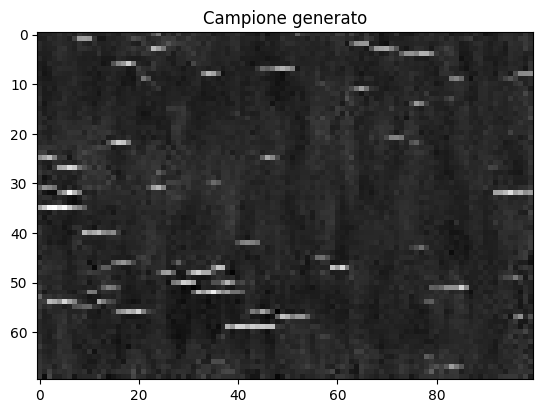

In [123]:
@torch.no_grad()
def sample(model, sample_shape):
    model.eval()
    x = torch.randn(sample_shape, device=device)
    for t in reversed(range(T)):
        beta_t = betas[t]
        alpha_t = alphas[t]
        alpha_bar_t = alphas_bar[t]
        t_emb = embeddings[t].unsqueeze(0).unsqueeze(0)
        predicted_noise = model(x, t_emb)
        noise = torch.randn_like(x) if t > 0 else torch.zeros_like(x)
        x = (1 / torch.sqrt(alpha_t)) * (x - ((1 - alpha_t) / torch.sqrt(1 - alpha_bar_t)) * predicted_noise) + torch.sqrt(beta_t) * noise
    return x

samples = sample(best_model, (1, 1, 70, 100))
sample_img = samples.cpu().squeeze().numpy()
print(samples.mean())
plt.imshow(sample_img, cmap='gray')
plt.title("Campione generato")
plt.show()

In [97]:
import pretty_midi

In [98]:
def midi_to_audio(midi_path, fs=44100, outputfile="output.wav"):
    if isinstance(midi_path, str):
        midi_data = pretty_midi.PrettyMIDI(midi_path)
    else:
        midi_data = midi_path
    audio = midi_data.synthesize(fs=fs)
    scaled_audio = np.int16(audio / np.max(np.abs(audio)) * 32767)
    write(outputfile, 44100, scaled_audio)
    return audio
def multi_hot_to_midi(piano_roll: np.ndarray, time_per_step: float = 0.05,
                      velocity: int = 100) -> pretty_midi.PrettyMIDI:
    """
    Convert a multi-hot encoded piano roll (2D NumPy array with shape (T, 128)) into a PrettyMIDI object.

    Parameters:
      piano_roll (np.ndarray): 2D array of shape (T, 128) where each row is a binary (or multi-hot) vector.
      time_per_step (float): Duration (in seconds) of each time step. Default is 0.05 sec.
      velocity (int): Velocity for note on events. Default is 100.

    Returns:
      pretty_midi.PrettyMIDI: A MIDI object representing the piano roll.
    """
    T, n_pitches = piano_roll.shape
    if n_pitches != 128:
        raise ValueError("The input piano roll must have 128 columns (for MIDI notes 0-127).")

    midi_obj = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=0)

    active_notes = {}

    for t in range(T):
        current_time = t * time_per_step
        current_frame = piano_roll[t]  # shape: (128,)

        for pitch in range(128):
            is_active = current_frame[pitch] > 0
            prev_active = piano_roll[t - 1][pitch] > 0 if t > 0 else False

            if is_active and not prev_active:
                active_notes[pitch] = current_time
            elif not is_active and prev_active:
                start_time = active_notes.pop(pitch, current_time)
                note = pretty_midi.Note(velocity=velocity, pitch=pitch, start=start_time, end=current_time)
                instrument.notes.append(note)

    final_time = T * time_per_step
    for pitch, start_time in active_notes.items():
        note = pretty_midi.Note(velocity=velocity, pitch=pitch, start=start_time, end=final_time)
        instrument.notes.append(note)

    midi_obj.instruments.append(instrument)
    return midi_obj

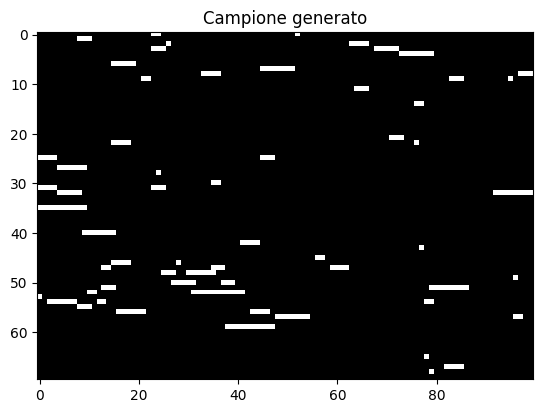

(128, 100)


In [125]:
from scipy.io.wavfile import write
mel = sample_img
mel[mel > 0] = 1
mel[mel < 0] = 0
plt.imshow(mel, cmap='gray')
plt.title("Campione generato")
plt.show()

blank = np.zeros((128, 100))
blank[30:100, :] = mel
print(blank.shape)
midi = multi_hot_to_midi(blank.T)
joblib.dump(midi, "pred.mid")
audio = midi_to_audio(midi)
import IPython
IPython.display.Audio(audio, rate=15_000)

In [ ]:
joblib.dump(pred, "pred5.pkl")


In [ ]:
torch.save(model.state_dict(), "BachDiff1.pt")